# Important Equations:
## Work:
The equation for the work done in the system can be found as:
$$W = - \int_{V_i}^{V_f}P(V)dV$$
Where the equation for pressure is:
$$P = \frac{nRT}{V}$$
Meaning work can be written as:
$$W = - nRT \int_{V_i}^{V_f} \frac{dV}{V}$$
$$W = nRT(ln(\frac{V_i}{V_f}))$$
When considering changes in temperature, the equation becomes:
$$\Delta W = nR(T_i - T_f)ln(V_i/V_f)$$
## Heat Conduction:
Fourier Heat Conduction Law can be used to find the conductivity of a material:
$$\frac{Q}{\Delta t}=-k_{t}A\frac{\Delta T}{\Delta x}$$
Where:
$\frac{Q}{\Delta t}$ is the rate of exchange of heat between sensors (In W, or J/S),
$k_T$ is the coefficient of thermal conductivity,
$A$ is the cross-sectional surface area between sensors (in $m^2$),
$\Delta T$ is the difference in temperature between sensors, $T_2 - T_1$ (in K), and
$\Delta x$ is the distance between the sensors (in m).

Thankfully, the power that the engine operates at is given by the product documentation as approximately 1 W, meaning that we can solve for the coefficient of thermal conductivity as:
$$k_t = - \frac{\Delta x}{\Delta T}\frac{1}{A}$$

## Efficiency:
The efficiency of the system can be found as:
$$\eta = \frac{T_f - T_i}{T_f + \frac{C_V (T_f - T_i)}{nR ln(V_f/V_i)}}$$
Where $C_V$ is:
$$C_V = \frac{nRf}{2}$$
Meaning $\eta$ can be rewritten as:
$$\eta = \frac{T_f - T_i}{T_f + \frac{f}{2}\frac{T_f - T_i}{ln(V_f/V_i)}}$$

In [1]:
# Creating functions
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema

R = 8.314
def delta_work(v_i, v_f, p_i, p_f, t_i, t_f):
    n_i = (p_i * v_i) / (R * t_i)
    n_f = (p_f * v_f) / (R * t_f)
    avg_n = (n_i + n_f)/2
    delta_T = t_i - t_f
    delta_w = avg_n * R * delta_T * np.log(v_i/v_f)
    return delta_w, avg_n

def n_est(v_i, v_f, p_i, p_f, t_i, t_f):
    n_i = (p_i * v_i) / (R * t_i)
    n_f = (p_f * v_f) / (R * t_f)
    avg_n = (n_i + n_f)/2
    return avg_n

def work(v_i, v_f, p_i, p_f, t_i, t_f):
    avg_n = n_est(v_i, v_f, p_i, p_f, t_i, t_f)
    work = avg_n * R * np.log(v_i/v_f)
    return work

def efficiency(t_f, t_i, v_f, v_i, f):
    efficiency = (t_f - t_i)/(t_f + (f/2)*((t_f - t_i)/(np.log(v_f/v_i))))
    return efficiency

def pressure_function(v, T, n):
    pressure = (n * R * T)/v
    return pressure

def fit_pressure(vol_data, press_data, estimates):
    popt, pcov = curve_fit(pressure_function, vol_data, press_data, p0=estimates)
    temp, n = popt
    sigma_temp, sigma_n = np.sqrt(np.diag(pcov))
    return temp, sigma_temp, n, sigma_n

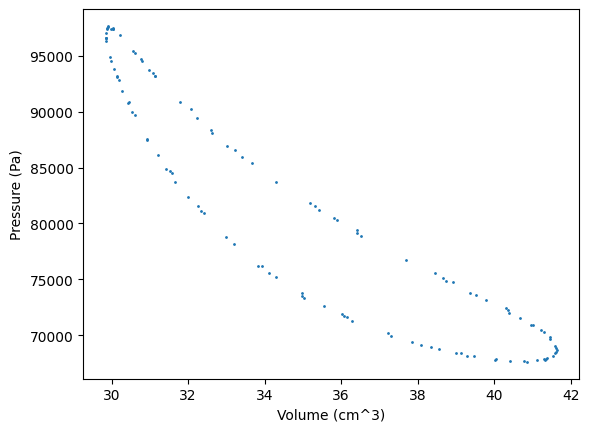

In [2]:
# Load data in dfs
df_1 = pd.read_csv("run1.csv", header=0, 
                   names=["time", "angle", "volume", "pressure","temp1", "temp2"])

time = df_1["time"]/1000 # s
radians = df_1["angle"]
volume = df_1["volume"] # cm^3
pressure = df_1["pressure"] * 1000 # Pa
heater_temp = df_1["temp1"] + 273.15 # K
heatsink_temp = df_1["temp2"] + 273.15 # K

plt.scatter(volume, pressure, s=1)
plt.xlabel("Volume (cm^3)")
plt.ylabel("Pressure (Pa)")
plt.show()

# Splitting graph into low and high pressure sections
In order to find the value for total work done in this process, we'll need to find the area of the graph between the high and low pressure sections of the graph. Or in other words, we can find the work of the high pressure section and subtract the work of the low pressure section to find only the work done between the two. In order to accomplish this, we must first split the data in half along where the data turns around in it's cycle in either direction.

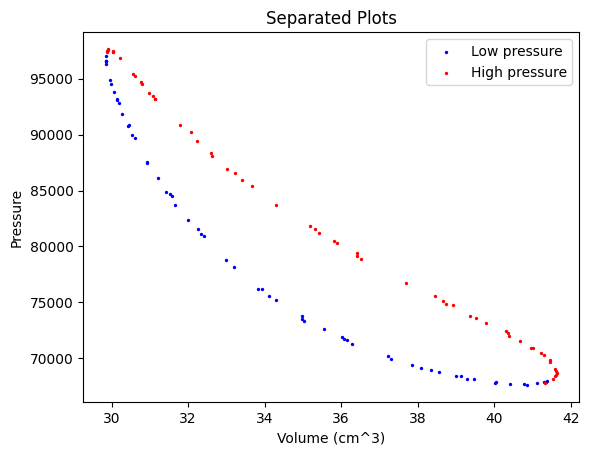

In [3]:
def lowerPresSection():
    lowSortingPres = np.zeros(len(pressure))

    for i, pres in enumerate(pressure):
        if (i+1) <= len(pressure) - 1:
            if pressure[i+1] >= pres:
                lowSortingPres[i] = pres
            elif pressure[i+1] <= pres:
                lowSortingPres[i] = 0
        else:
            lowSortingPres[i] = 0
            break

    low_pressure = []
    low_volume = []
    for i, lowPres in enumerate(lowSortingPres):
        if lowPres > 0:
            low_pressure.append(lowPres)
            low_volume.append(volume[i])

    return low_volume, low_pressure

def higherPresSection():
    highSortingPres = np.zeros(len(pressure))
    for i, pres in enumerate(pressure):
        if (i+1) <= len(pressure) - 1:
            if pressure[i+1] <= pres:
                highSortingPres[i] = pres
            elif pressure[i+1] >= pres:
                highSortingPres[i] = 0
        else:
            highSortingPres[i] = 0
            break
    high_pressure = []
    high_volume = []
    for i, highPres in enumerate(highSortingPres):
        if highPres > 0:
            high_pressure.append(highPres)
            high_volume.append(volume[i])

    return high_volume, high_pressure

low_volume, low_pressure = lowerPresSection()
high_volume, high_pressure = higherPresSection()

# Sorting plots to remove discontinuities caused by different cycles
sorted_low_pressure = sorted(zip(low_volume, low_pressure), key=lambda x: x[0])
sorted_lvolume, sorted_lpressure = zip(*sorted_low_pressure)
plt.scatter(sorted_lvolume, sorted_lpressure, s=2, color="blue")

sorted_high_pressure = sorted(zip(high_volume, high_pressure), key=lambda x: x[0])
sorted_hvolume, sorted_hpressure = zip(*sorted_high_pressure)
plt.scatter(sorted_hvolume, sorted_hpressure, s=2, color="red")

plt.title("Separated Plots")
plt.xlabel("Volume (cm^3)")
plt.ylabel("Pressure")
plt.legend(["Low pressure", "High pressure"])

plt.show()

v_i, v_f = sorted_lvolume[0], sorted_lvolume[-1]
p_i, p_f = sorted_lpressure[0], sorted_lpressure[-1]



# Finding $T_i$ and $T_f$:
In order to accurately determine the work done by the engine, it will be necessary to calculate the initial and final temperatures as the engine performs (initial and final corresponding to the minimum and maximum compression states of the piston respectively). Unfortunately, when plotted against pressure, the temperatures as recorded do not seem to evolve coherently, so we'll have to go through a complicated process to find useful estimates:

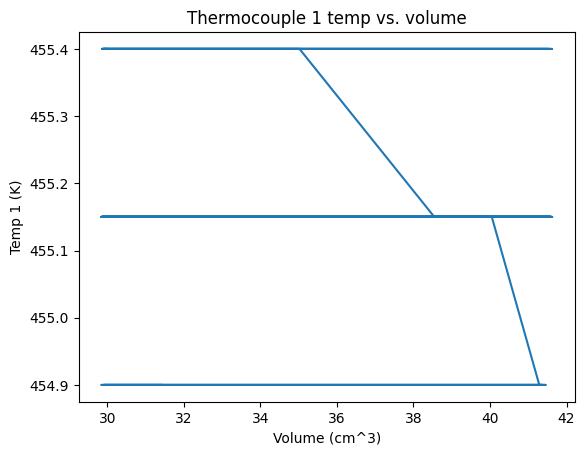

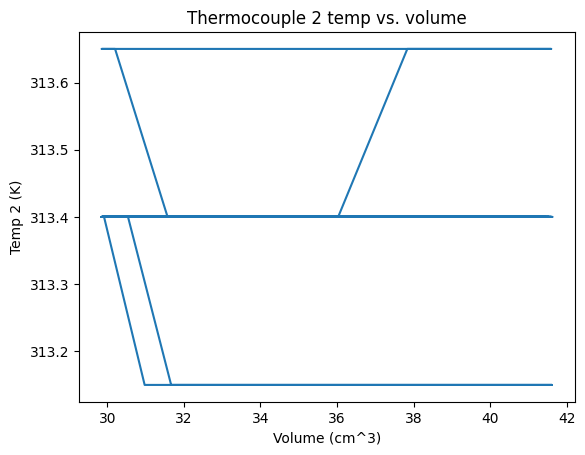

In [12]:
plt.plot(volume, heater_temp)
plt.xlabel(f'Volume (cm^3)')
plt.ylabel(f'Temp 1 (K)')
plt.title('Thermocouple 1 temp vs. volume')
plt.show()

plt.plot(volume, heatsink_temp)
plt.xlabel(f'Volume (cm^3)')
plt.ylabel(f'Temp 2 (K)')
plt.title('Thermocouple 2 temp vs. volume')
plt.show()

There are many things that could cause this result. A few culprits could be: 

1. The recording of data not beginning until the system was already hot enough. As the system is not idealized, it's capabilities for cooling as the piston expands and cools may be drastically reduced compared its theoretical model.
2. The heat source being a blow dryer. This could cause a more even temperature gradient across the system which a more localized, direct flame, might not have. 
3. Faulty thermocouple sensors. It could be that the sensors need to be calibrated or replaced in order to give a more accurate temperature.
4. Combinations of the above. 

Let's instead try to find what the temperature function *should* look like. Let's assume that one of the sensors is recording the temperature correctly as the temperature at the initial volume. To do this, we can plot:
$$T = PV/nR$$ 
Using our pressure and volume data, now only needing to find a value for $n$, which can done easily by reaaranging to:
$$n = PV/RT$$
Let's estimate a value for $n$ using both temperatures as measured (since they don't differ much at the maxima and minima of the pressure/volume function), then use the average values of $P$ and $V$ at the extrema, and compare them before plotting how the temperature should have evolved with the system.

Avg high heater temp: 455.15000 K, Avg low heater temp: 455.15000
t_f - t_i: 0.0 K
Avg high heatsink temp: 313.43125 K, Avg low heatsink temp: 313.40000
t_f - t_i: 0.03125 K
Average high volume: 0.00 m^3, Avg low volume: 0.00 m^3
Average high pressure: 97413.33 Pa, Avg low pressure: 67805.18 Pa

n estimate with heater:
n_i: 7.33e-04,
n_f: 7.72e-04
avg: 7.52e-04

n estimate with heatsink:
n_i: 1.06e-03,
n_f: 1.12e-03
avg: 1.09e-03


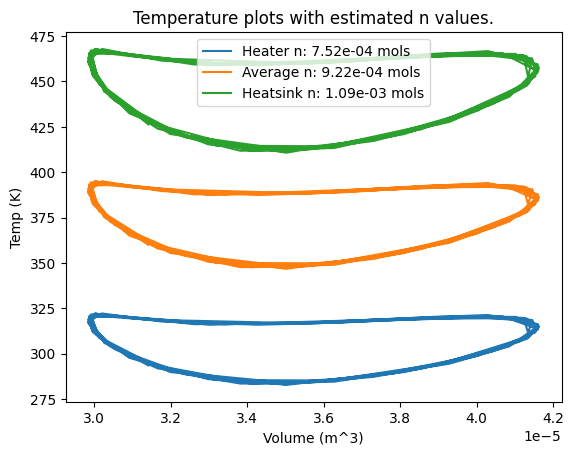

In [16]:
# Find minima and maxima of pressure across cycles
volume_m3 = volume / 1e6
array_pressure = np.array(pressure)

max_indices = argrelextrema(array_pressure, np.greater, order=5)[0]
min_indices = argrelextrema(-array_pressure, np.greater, order=5)[0]

# Find the corresponding values for temperatures across the sensors
sampled_high_heater_temps = heater_temp.loc[max_indices]
sampled_low_heater_temps = heater_temp.loc[min_indices]

avg_high_heater_temp = sum(sampled_high_heater_temps)/len(sampled_high_heater_temps)
avg_low_heater_temp = sum(sampled_low_heater_temps)/len(sampled_low_heater_temps)

high_heatsink_temps = heatsink_temp.loc[max_indices]
low_heatsink_temps = heatsink_temp.loc[min_indices]

avg_high_heatsink_temp = sum(high_heatsink_temps)/len(high_heatsink_temps)
avg_low_heatsink_temp = sum(low_heatsink_temps)/len(low_heatsink_temps)

print(f'Avg high heater temp: {avg_high_heater_temp:.5f} K, Avg low heater temp: {avg_low_heater_temp:.5f}')
print(f't_f - t_i: {avg_high_heater_temp - avg_low_heater_temp} K')
print(f'Avg high heatsink temp: {avg_high_heatsink_temp:.5f} K, Avg low heatsink temp: {avg_low_heatsink_temp:.5f}')
print(f't_f - t_i: {avg_high_heatsink_temp - avg_low_heatsink_temp} K')

high_vol_values = volume_m3.loc[max_indices]
low_vol_values = volume_m3.loc[min_indices]

avg_high_vol = sum(high_vol_values)/len(high_vol_values)
avg_low_vol = sum(low_vol_values)/len(low_vol_values)
print(f"Average high volume: {avg_high_vol:.2f} m^3, Avg low volume: {avg_low_vol:.2f} m^3")

# estimating pressure maxima and minima
high_press_values = pressure.loc[max_indices]
low_press_values = pressure.loc[min_indices]

avg_high_press = sum(high_press_values)/len(high_press_values)
avg_low_press = sum(low_press_values)/len(low_press_values)
print(f"Average high pressure: {avg_high_press:.2f} Pa, Avg low pressure: {avg_low_press:.2f} Pa")

# setting temp vars
heater = avg_high_heater_temp
heatsink = (avg_high_heatsink_temp + avg_low_heatsink_temp)/2

# estimating n using heater values
n_heater_f_est = (avg_high_press * avg_high_vol)/(8.314 * heater)
n_heater_i_est = (avg_low_press * avg_low_vol)/(8.314 * heater)
n_heater_avg = (n_heater_i_est + n_heater_f_est)/2
print(f"\nn estimate with heater:\nn_i: {n_heater_i_est:.2e},\nn_f: {n_heater_f_est:.2e}\navg: {n_heater_avg:.2e}")

# estimating n using heatsink values
n_heatsink_f_est = (avg_high_press * avg_high_vol)/(8.314 * heatsink)
n_heatsink_i_est = (avg_low_press * avg_low_vol)/(8.314 * heatsink)
n_heatsink_avg = (n_heatsink_i_est + n_heatsink_f_est)/2
print(f"\nn estimate with heatsink:\nn_i: {n_heatsink_i_est:.2e},\nn_f: {n_heatsink_f_est:.2e}\navg: {n_heatsink_avg:.2e}")

n_avg = (n_heatsink_avg + n_heater_avg)/2

temp_heater_n_est = (pressure * (volume_m3)) / (n_heater_avg * R)
temp_heatsink_n_est = (pressure * (volume_m3)) / (n_heatsink_avg * R)
avg_n_est = (temp_heater_n_est + temp_heatsink_n_est)/2

plt.plot(volume_m3, temp_heatsink_n_est, label=f"Heater n: {n_heater_avg:.2e} mols")
plt.plot(volume_m3, avg_n_est, label=f"Average n: {n_avg:.2e} mols")
plt.plot(volume_m3, temp_heater_n_est, label=f"Heatsink n: {n_heatsink_avg:.2e} mols")
plt.xlabel("Volume (m^3)")
plt.ylabel("Temp (K)")
plt.title("Temperature plots with estimated n values.")
plt.legend()
plt.show()

# Finding the Coefficient of Conductivity:

In [14]:
# finding deltas t and T
temp2_max = max(heatsink_temp)
temp2_index = heatsink_temp.idxmax()
time_temp2_max = time[temp2_index]
print(f'Thermocouple 2 had a temperature of {temp2_max:.2f} K at {time_temp2_max:.2f} s')
print(f'At the same time, thermocouple 1 had a temperature of {heater_temp[temp2_index]:.2f} K.')
delta_T = temp2_max -heater_temp[temp2_index]
print(f'This gives a value for Delta T of {delta_T:.2f} K')

Thermocouple 2 had a temperature of 313.65 K at 0.27 s
At the same time, thermocouple 1 had a temperature of 455.15 K.
This gives a value for Delta T of -141.50 K


The remaining variables to be able to find the conductivity are then the cross sectional areas shared by the glass and air as well as the distance between the couples. 

The couples are rougly 8cm apart, or 0.08 m.

Assuming the glass has a thickness of 1mm and the thermocouple has a diameter of 5mm, that would mean the glass has a cross sectional surface area of $5mm^2$ or $5x10^{-6}m^2$.

The documentation for the engine says that the change in volume caused by the piston is $12cm^3$ ($1.2 x 10^{-5} m^3$), and that the path of the piston is 24mm (0.024m) long. As it traces out a cylinder, this means that we can use $V = \pi r^2 h$ where h is the length of the path to find $r=\sqrt{\frac{V}{\pi h}} = \sqrt{\frac{1.2e-5 m^3}{\pi 0.024 m}}=1.26x10^{-2} m$, meaning the additional area, $A=\pi r^2$ is equal to $4.99x10^{-4}m^2$

This gives a total cross sectional area of $5.04x10^{-4}m^2$.

In [7]:
k_engine = -(4e-2/5.04e-4)/delta_T
print(k_engine)

0.5608839531101015


In [8]:
p_i = max(pressure)
p_f = min(pressure)

index_i = pressure.idxmax()
index_f = pressure.idxmin()

v_i = volume.loc[index_i]
v_f = volume.loc[index_f]

t1_i = heater_temp.loc[index_i]
t1_f = heater_temp.loc[index_f]

t2_i = heatsink_temp.loc[index_i]
t2_f = heatsink_temp.loc[index_f]

print(f'Max pressure: {p_i:.2f} Pa, Volume: {v_i:.2e} m^3')
print(f"Temp1: {t1_i:.2f} K")
print(f"Temp2: {t2_i:.2f} K")
print(f'Min pressure: {p_f:.2f} Pa, Volume: {v_f:.2e} m^3')
print(f"Temp1: {t1_f:.2f} K")
print(f"Temp2: {t2_f:.2f} K")

delta_w, n_avg = delta_work(v_i, v_f, p_i, p_f, (t1_i+t2_i)/2, (t1_f+t2_f)/2)
print(f'Estimated value for n = {n_avg:.2e} mols')
print(f'Estimated value for delta W = {delta_w:.2e} J')

Max pressure: 97663.57 Pa, Volume: 2.99e+01 m^3
Temp1: 454.90 K
Temp2: 313.40 K
Min pressure: 67622.07 Pa, Volume: 4.09e+01 m^3
Temp1: 455.40 K
Temp2: 313.15 K
Estimated value for n = 8.90e+02 mols
Estimated value for delta W = 2.88e+02 J
